# Tâche n°9 : Modèles de chaleur spécifique et DOS

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import quad




In [2]:
with MPRester("yDHrTj9RRkoKjTjOFwD0btKpsIOcE65N") as m:

    
    structure = m.get_structure_by_material_id("mp-20072")
    ph_struct = m.get_phonon_bandstructure_by_material_id("mp-20072")
    ph_dos = m.get_phonon_dos_by_material_id("mp-20072")
    

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# 1. Calcule des températures de Debye et d'Einstein 

À partir des données de la chaleur spécifique phononique du matériau étudié, nous pouvons estimer les températures caractéristiques d’Einstein (𝜃<sub>E</sub>) et de Debye (𝜃<sub>D</sub>).  
Ces températures sont déterminées en minimisant l’erreur entre la chaleur spécifique théorique, donnée par les modèles d’Einstein et de Debye, et les données calculées à partir de la densité d’états phononique.

---

#### Modèle d'Einstein

Le modèle d’Einstein suppose que tous les atomes du réseau vibrent à la même fréquence \( \omega_E \), qui est la fréquence naturelle de vibration.  
On introduit alors la température d'Einstein $ \Theta_E $, définie par la relation :

$
k_B \Theta_E = \hbar \omega_E
$

Cette température permet d’exprimer la chaleur spécifique molaire (normalisée) sous la forme :

$
\frac{C_v}{3N_{\text{at}} R} = \left( \frac{\Theta_E}{T} \right)^2 \cdot \frac{e^{\Theta_E / T}}{\left(e^{\Theta_E / T} - 1\right)^2}
$

Nous ajustons cette expression théorique aux données numériques en utilisant une méthode de régression non linéaire (`curve_fit`), afin d’estimer la valeur de $\Theta_E$ qui décrit le mieux le comportement thermique du matériau


---

#### Modèle de Debye

Le modèle de Debye, lui, suppose que les vibrations du réseau couvrent un spectre continu de fréquences, avec une dispersion linéaire  
$\omega(\vec{q}) = vq$, où \( v \) est la vitesse de phase.  
On détermine alors la température de Debye 𝜃<sub>D</sub> telles que $k_B \Theta_D = \hbar \omega_D = \hbar vq_d$


Cette température permet de définir la chaleur spécifique (normalisée) par l’expression théorique du modèle de Debye :

$
\frac{C_v}{3 N_{\text{at}} R} = 3 \left( \frac{T}{\Theta_D} \right)^3 \int_0^{\Theta_D / T} \frac{x^4 e^x}{(e^x - 1)^2} dx
$

Comme cette expression ne peut pas être résolue analytiquement, l’intégrale est calculée numériquement, puis la température $\Theta_D $ est ajustée en minimisant l’écart entre cette courbe théorique et les données calculées à partir de la densité d’états phononique (via `curve_fit`).



In [3]:



R = 8.314
#nombre d'atomes dans la maille primitive
N_at = len(structure)
temperatures = np.arange(5, 1000, 5)

# Chaleurs spécifiques normalisées (par 3 * nat * R)
ph_cv = np.array([ph_dos.cv(T) for T in temperatures]) / (3 * N_at * R)

#Température d'Einstein 

curve_einstein = lambda T, theta_E: (theta_E / T)**2 * np.exp(theta_E / T) / (np.exp(theta_E / T) - 1)**2

# déterminer theta_E avec curve_fit 
theta_E, _ = curve_fit(curve_einstein, temperatures, ph_cv)[0:2]
print("Température d'Einstein estimée (K) :", theta_E)

#Température de Debye

def temp_debye(T, theta_D):
    resultats = []
    for t in T:
        integrale, _ = quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, theta_D / t)
        cv = 3 * (t / theta_D)**3 * integrale
        resultats.append(cv)
    return np.array(resultats)

# déterminer theta_D avec curve_fit 
theta_D, _ = curve_fit(lambda T, theta_D: temp_debye(T, theta_D), temperatures, ph_cv)[0:2]
print("Température de Debye estimée (K) :", theta_D)



Température d'Einstein estimée (K) : [340.46735224]
Température de Debye estimée (K) : [463.60046714]


# 2. Représentation des trois courbes de chaleur spécifique

Grâce à l’estimation des températures caractéristiques d’Einstein ($\Theta_E$) et de Debye ($\Theta_D$) obtenues précédemment, nous pouvons comparer les prédictions de ces deux modèles théoriques à la chaleur spécifique phononique calculée à partir de la densité d'états.

Le graphique ci-dessous représente :

- en bleu : la chaleur spécifique normalisée calculée à partir des données phononiques du matériau ;
- en vert : la prédiction du modèle d’Einstein utilisant la température $\Theta_E$ trouvée au point 2 ;
- en rouge : la prédiction du modèle de Debye utilisant la température $\Theta_D$ trouvée au point2.


Les différences entre ces deux modèles apparaissent lorsqu’on observe leur comportement en fonction de la température:

### Modèle d’Einstein :
- Pour $ T \gg \Theta_E $, la chaleur spécifique tend vers la limite classique de Dulong-Petit :
  $
  C_v \to 3 N_{\text{at}} R
  $
- Pour $ T \ll \Theta_E $, elle chute de manière exponentielle :
  $
  C_v \propto e^{-\Theta_E / T}
  $

### Modèle de Debye :
- Pour $ T \gg \Theta_D $, on retrouve également la limite classique :
  $
  C_v \to 3 N_{\text{at}} R
  $
- Pour $ T \ll \Theta_D $, la chaleur spécifique suit une loi en puissance de la température :
  $
  C_v \propto T^3
  $

Ces comportements limites expliquent pourquoi le modèle de Debye correspond bien aux données sur toute la plage de température, en particulier à basse température, contrairement au modèle d’Einstein qui surestime la décroissance de $C_v $.



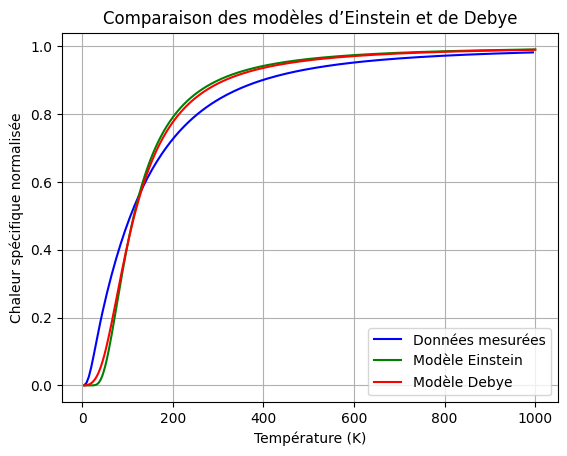

In [4]:


T_plot = np.linspace(5, 1000, 500)

# Courbe Einstein
x_E = theta_E / T_plot
cv_E = (x_E**2 * np.exp(x_E)) / (np.exp(x_E) - 1)**2

# Courbe Debye
cv_D = []
for t in T_plot:
    I, _ = quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, theta_D / t)
    cv_D.append(3 * (t / theta_D)**3 * I)
cv_D = np.array(cv_D)


plt.plot(temperatures, ph_cv, 'b-', label='Données mesurées')
plt.plot(T_plot, cv_E, 'g', label='Modèle Einstein')
plt.plot(T_plot, cv_D, 'r', label='Modèle Debye')
plt.xlabel("Température (K)")
plt.ylabel("Chaleur spécifique normalisée")
plt.legend()
plt.title("Comparaison des modèles d’Einstein et de Debye")
plt.grid()
plt.show()


# 3. Représentation des trois densités d'états de phonons correspondantes

À partir des températures caractéristiques précédemment déterminées, on peut maintenant représenter les densités d’états phononiques associées aux modèles d’Einstein et de Debye, et les comparer à la densité d’états obtenue par simulation (ou expérience).

#### Modèle d’Einstein

Dans le modèle d’Einstein, on suppose que toutes les vibrations du cristal ont la même fréquence $\omega_E$.  
La densité d’états phononique (DOS) est alors représentée par un pic unique à cette fréquence, ce qui revient mathématiquement à une impulsion de Dirac en $\omega_E$ :

$
g_E(\omega) = 3N_{\text{at}} \, \delta(\omega - \omega_E)
$

Ce facteur 3 provient des 3 degrés de liberté vibratoires par atome.  
Sur le graphique, elle est représentée par une ligne verticale à la fréquence $\omega_E$. Même si elle paraît s’arrêter, elle représente en fait une ligne infinie, car elle modélise un delta de Dirac.

#### Modèle de Debye

Le modèle de Debye considère une répartition continue des fréquences allant de 0 jusqu'à une fréquence maximale $\omega_D$, avec une densité d'états parabolique :

$
g_D(\omega) = \frac{3N_{\text{at}} \, \Omega \, \omega^2 \, q_D^3}{2\pi^2 \, v^3 \, \omega_D^3} \quad \text{si } \omega < \omega_D,\quad \text{et } g_D(\omega) = 0 \text{ sinon}
$

où :

- $\Omega$ est le volume de la cellule unitaire,
- $q_D = \left(\frac{6\pi^2}{\Omega}\right)^{1/3}$ est la limite du vecteur d’onde dans le modèle de Debye.

Ce modèle respecte la condition de normalisation : l’aire totale sous la courbe de la DOS doit être égale à $3N_{\text{at}}$.

#### Comparaison graphique

Le graphique ci-dessous compare :

- la densité d’états réelle obtenue par simulation (en bleu),
- la représentation du modèle d’Einstein (en vert),
- et celle du modèle de Debye (en rouge).

Cette comparaison permet de visualiser comment chaque modèle idéalise la distribution des fréquences vibratoires du cristal.


Fréquence d’Einstein (THz) : 7.094188540124382
Fréquence de Debye (THz) : 9.659866355987598


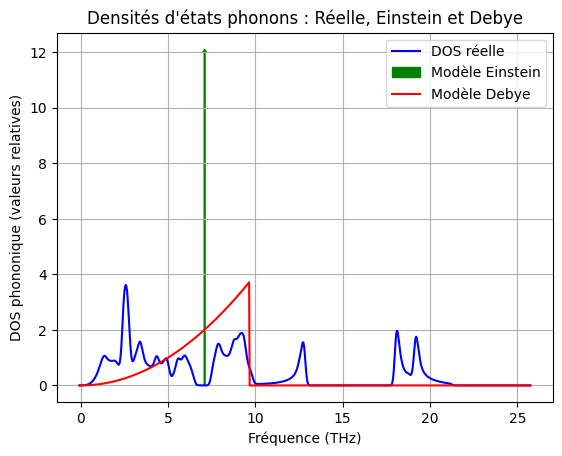

In [5]:

hbar = 1.054571818e-34 
k_B = 1.380649e-23      


theta_E = theta_E.item()
theta_D = theta_D.item()

# Données de référence
frequencies = ph_dos.frequencies      # Fréquences [THz]
density_ref = ph_dos.densities        # Densité d'états phonons
plt.plot(frequencies, density_ref, label="DOS réelle", color='blue')

# Fréquence d’Einstein
omega_E = (k_B * theta_E) / (hbar * 2 * np.pi)      # En Hz
omega_E_THz = omega_E * 1e-12                       # En THz
print("Fréquence d’Einstein (THz) :", omega_E_THz)

# Densité d’états selon le modèle d’Einstein (flèche vertical => impulsion de Dirac)
plt.arrow(omega_E_THz, 0, 0, 3 * N_at, width=0.05, head_width=0.2, head_length=0.1, fc='green', ec='green', label='Modèle Einstein')


# Fréquence de Debye
omega_D = (k_B * theta_D) / (hbar * 2 * np.pi) * 1e-12  # En THz
print("Fréquence de Debye (THz) :", omega_D)

# Volume de la cellule unitaire (en Å³)
volume_uc = structure.volume


q_D = (6 * np.pi**2 / volume_uc)**(1/3)

# Densité d’états selon le modèle de Debye
density_debye = np.zeros_like(frequencies)
for i, f in enumerate(frequencies):
    if f < omega_D:
        density_debye[i] = (3 * N_at * volume_uc * f**2 * q_D**3) / (2 * np.pi**2 * omega_D**3)
    else:
        density_debye[i] = 0


plt.plot(frequencies, density_debye, label='Modèle Debye', color='red')


plt.title("Densités d'états phonons : Réelle, Einstein et Debye")
plt.xlabel("Fréquence (THz)")
plt.ylabel("DOS phononique (valeurs relatives)")
plt.legend()
plt.grid(True)
plt.show()
